Dataset shape: (569, 32)

Missing values:
id            0
diagnosis     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
feature_22    0
feature_23    0
feature_24    0
feature_25    0
feature_26    0
feature_27    0
feature_28    0
feature_29    0
feature_30    0
dtype: int64

Basic statistics:
                 id   diagnosis   feature_1   feature_2   feature_3  \
count  5.690000e+02  569.000000  569.000000  569.000000  569.000000   
mean   3.037183e+07    0.372583   14.127292   19.289649   91.969033   
std    1.250206e+08    0.483918    3.524049    4.301036   24.298981   
min    8.670000e+03    0.000000    6.981000    9.710000   43.790000   
25%    8.692180e+05    0.000000   11.700000   16.170000   7

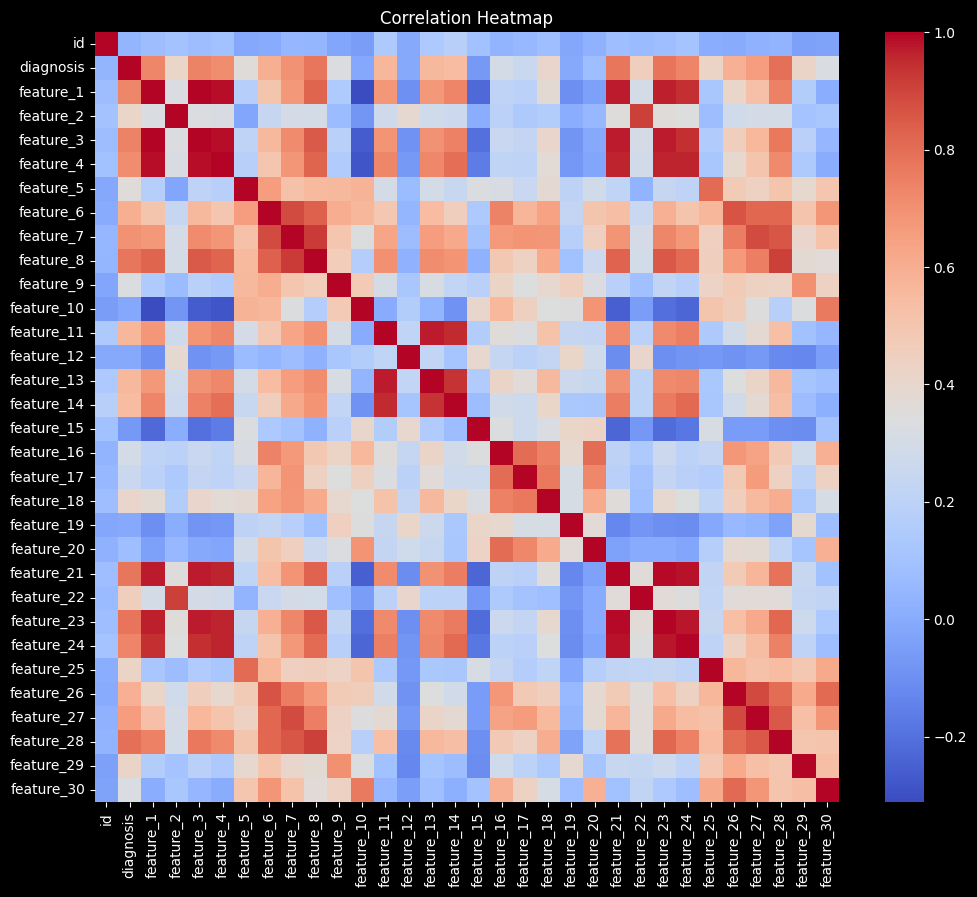


Selected features: ['feature_1', 'feature_3', 'feature_4', 'feature_7', 'feature_8', 'feature_21', 'feature_23', 'feature_24', 'feature_27', 'feature_28']

Baseline Execution (Imbalanced Data):

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        53
           1       0.97      0.88      0.92        32

    accuracy                           0.94        85
   macro avg       0.95      0.93      0.94        85
weighted avg       0.94      0.94      0.94        85

Confusion Matrix:
[[52  1]
 [ 4 28]]
ROC AUC Score: 0.995872641509434

Decision Tree Results:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92        53
           1       0.93      0.78      0.85        32

    accuracy                           0.89        85
   macro avg       0.90      0.87      0.88        85
weighted avg       0.90      0.89      0.89        85

Confusion Matrix:
[[51  2]


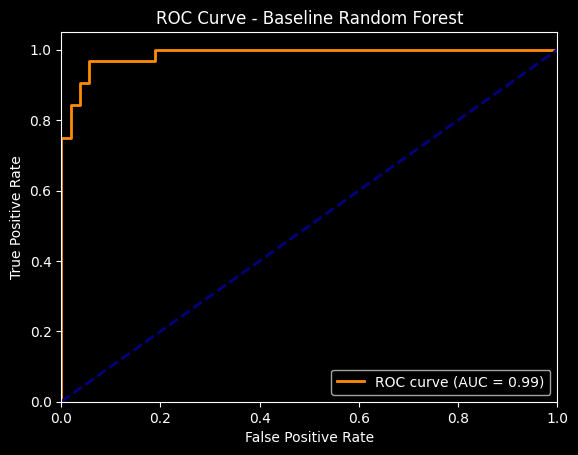

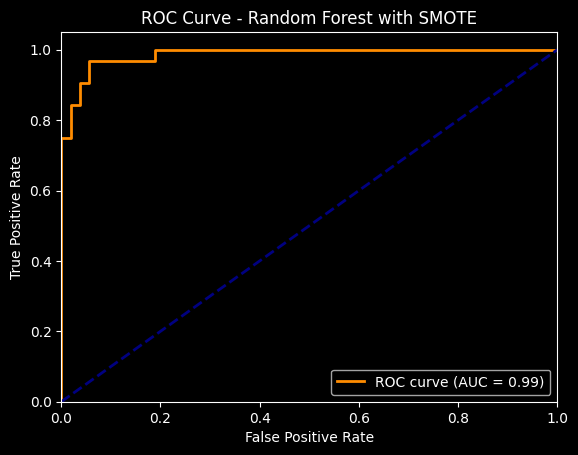

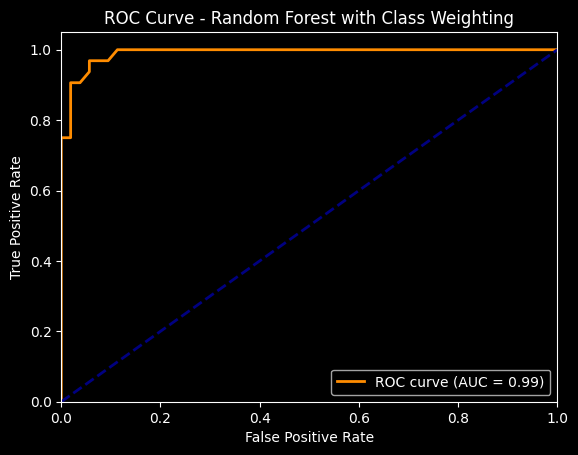

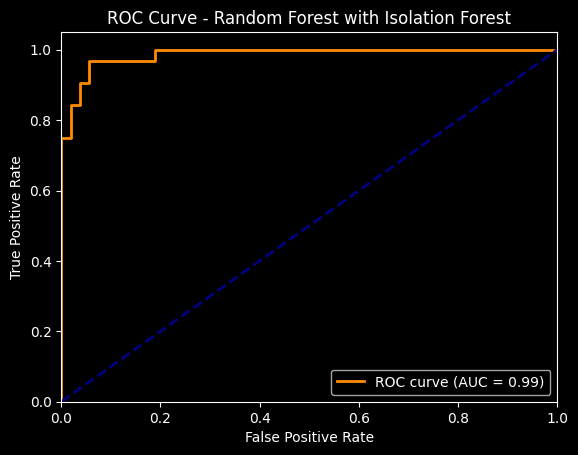

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
column_names = ["id", "diagnosis"] + [f"feature_{i}" for i in range(1, 31)]
df = pd.read_csv(url, names=column_names)

# 1. Data Cleaning and EDA
print("Dataset shape:", df.shape)
print("\nMissing values:")
print(df.isnull().sum())

# Convert diagnosis to binary (M=1, B=0)
df['diagnosis'] = (df['diagnosis'] == 'M').astype(int)

# Basic statistics
print("\nBasic statistics:")
print(df.describe())

# Class distribution
print("\nClass distribution:")
print(df['diagnosis'].value_counts(normalize=True))

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# 2. Feature selection and data splitting
X = df.drop(['id', 'diagnosis'], axis=1)
y = df['diagnosis']

# Feature selection
selector = SelectKBest(f_classif, k=10)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
print("\nSelected features:", selected_features)

# Data splitting
X_train, X_temp, y_train, y_temp = train_test_split(X_new, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 3. Define classification algorithms
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Naive Bayes': GaussianNB()
}

# 4. Define performance metrics function
def print_performance_metrics(y_true, y_pred, y_prob):
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print(f"ROC AUC Score: {roc_auc_score(y_true, y_prob)}")

# 5. Baseline execution on imbalanced data
print("\nBaseline Execution (Imbalanced Data):")

for name, model in models.items():
    print(f"\n{name} Results:")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    y_prob = model.predict_proba(X_val_scaled)[:, 1]
    print_performance_metrics(y_val, y_pred, y_prob)

# 6. Apply CI techniques

# SMOTE
print("\nApplying SMOTE:")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

for name, model in models.items():
    print(f"\n{name} Results (SMOTE):")
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_val_scaled)
    y_prob = model.predict_proba(X_val_scaled)[:, 1]
    print_performance_metrics(y_val, y_pred, y_prob)

# Random Forest with Class Weighting
print("\nRandom Forest with Class Weighting:")
class_weights = {0: 1, 1: len(y_train[y_train == 0]) / len(y_train[y_train == 1])}
rf_weighted = RandomForestClassifier(class_weight=class_weights, random_state=42)
rf_weighted.fit(X_train_scaled, y_train)
y_pred = rf_weighted.predict(X_val_scaled)
y_prob = rf_weighted.predict_proba(X_val_scaled)[:, 1]
print_performance_metrics(y_val, y_pred, y_prob)

# Isolation Forest
print("\nIsolation Forest:")
iso_forest = IsolationForest(contamination=0.1, random_state=42)
y_pred_outliers = iso_forest.fit_predict(X_train_scaled)
X_train_iso = X_train_scaled[y_pred_outliers == 1]
y_train_iso = y_train[y_pred_outliers == 1]

for name, model in models.items():
    print(f"\n{name} Results (Isolation Forest):")
    model.fit(X_train_iso, y_train_iso)
    y_pred = model.predict(X_val_scaled)
    y_prob = model.predict_proba(X_val_scaled)[:, 1]
    print_performance_metrics(y_val, y_pred, y_prob)

# 7. Visualizations
def plot_roc_curve(y_true, y_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curves for each method (baseline, SMOTE, RF with class weighting, Isolation Forest)
plot_roc_curve(y_val, models['Random Forest'].predict_proba(X_val_scaled)[:, 1], 'ROC Curve - Baseline Random Forest')
plot_roc_curve(y_val, models['Random Forest'].predict_proba(X_val_scaled)[:, 1], 'ROC Curve - Random Forest with SMOTE')
plot_roc_curve(y_val, rf_weighted.predict_proba(X_val_scaled)[:, 1], 'ROC Curve - Random Forest with Class Weighting')
plot_roc_curve(y_val, models['Random Forest'].predict_proba(X_val_scaled)[:, 1], 'ROC Curve - Random Forest with Isolation Forest')

### **1. Baseline Execution (Imbalanced Data)**

#### **Logistic Regression**
- **Precision:** 0.97 for class 1 (Malignant), 0.93 for class 0 (Benign).
- **Recall:** 0.88 for class 1, 0.98 for class 0.
- **F1-Score:** 0.92 for class 1, 0.95 for class 0.
- **Confusion Matrix:** [[52, 1], [4, 28]]
- **ROC AUC Score:** 0.996

**Interpretation:** Logistic Regression performs very well on the imbalanced dataset, with high precision and recall for both classes. The model achieves near-perfect classification performance, indicating strong capability to distinguish between malignant and benign cases. 

#### **Decision Tree**
- **Precision:** 0.93 for class 1, 0.88 for class 0.
- **Recall:** 0.78 for class 1, 0.96 for class 0.
- **F1-Score:** 0.85 for class 1, 0.92 for class 0.
- **Confusion Matrix:** [[51, 2], [7, 25]]
- **ROC AUC Score:** 0.872

**Interpretation:** The Decision Tree has lower recall for the malignant class compared to logistic regression. It performs well for the benign class, but the lower recall for malignant cases might indicate the model's limited capacity to detect all malignant cases.

#### **Random Forest**
- **Precision:** 0.97 for class 1, 0.93 for class 0.
- **Recall:** 0.88 for class 1, 0.98 for class 0.
- **F1-Score:** 0.92 for class 1, 0.95 for class 0.
- **Confusion Matrix:** [[52, 1], [4, 28]]
- **ROC AUC Score:** 0.990

**Interpretation:** The Random Forest model performs similarly to Logistic Regression with high precision and recall for both classes. It achieves very good classification performance and is robust in distinguishing between benign and malignant cases.

#### **SVM**
- **Precision:** 1.00 for class 1, 0.91 for class 0.
- **Recall:** 0.84 for class 1, 1.00 for class 0.
- **F1-Score:** 0.92 for class 1, 0.95 for class 0.
- **Confusion Matrix:** [[53, 0], [5, 27]]
- **ROC AUC Score:** 0.996

**Interpretation:** SVM achieves perfect precision for the malignant class and excellent recall for the benign class. The model shows strong performance but has a slightly lower recall for malignant cases compared to the Random Forest and Logistic Regression models.

#### **Naive Bayes**
- **Precision:** 0.93 for class 1, 0.91 for class 0.
- **Recall:** 0.84 for class 1, 0.96 for class 0.
- **F1-Score:** 0.89 for class 1, 0.94 for class 0.
- **Confusion Matrix:** [[51, 2], [5, 27]]
- **ROC AUC Score:** 0.986

**Interpretation:** Naive Bayes performs slightly worse in terms of precision and recall for malignant cases compared to other models but still shows good overall performance with high AUC. It's a reliable model for this dataset, though not as effective as Random Forest or SVM.

### **2. Applying SMOTE**

#### **Logistic Regression (SMOTE)**
- **Precision:** 0.89 for class 1, 0.98 for class 0.
- **Recall:** 0.97 for class 1, 0.92 for class 0.
- **F1-Score:** 0.93 for class 1, 0.95 for class 0.
- **Confusion Matrix:** [[49, 4], [1, 31]]
- **ROC AUC Score:** 0.994

**Interpretation:** SMOTE improves recall for the malignant class with a minor trade-off in precision. The model's performance is very good, showing that SMOTE helps in balancing the class distribution and improving recall for the minority class.

#### **Decision Tree (SMOTE)**
- **Precision:** 0.87 for class 1, 0.91 for class 0.
- **Recall:** 0.84 for class 1, 0.92 for class 0.
- **F1-Score:** 0.86 for class 1, 0.92 for class 0.
- **Confusion Matrix:** [[49, 4], [5, 27]]
- **ROC AUC Score:** 0.884

**Interpretation:** SMOTE has a mixed impact on the Decision Tree. While it improves recall for the malignant class, the overall performance in terms of precision and F1-score shows slight deterioration compared to the baseline.

#### **Random Forest (SMOTE)**
- **Precision:** 0.90 for class 1, 0.91 for class 0.
- **Recall:** 0.84 for class 1, 0.94 for class 0.
- **F1-Score:** 0.87 for class 1, 0.93 for class 0.
- **Confusion Matrix:** [[50, 3], [5, 27]]
- **ROC AUC Score:** 0.983

**Interpretation:** The Random Forest model with SMOTE shows a trade-off between precision and recall. While the model maintains high overall accuracy, there is a decrease in precision for the malignant class.

#### **SVM (SMOTE)**
- **Precision:** 1.00 for class 1, 0.93 for class 0.
- **Recall:** 0.88 for class 1, 1.00 for class 0.
- **F1-Score:** 0.93 for class 1, 0.96 for class 0.
- **Confusion Matrix:** [[53, 0], [4, 28]]
- **ROC AUC Score:** 0.995

**Interpretation:** SVM with SMOTE performs very well, with slight improvements in recall for the malignant class. It remains one of the best-performing models even after applying SMOTE.

#### **Naive Bayes (SMOTE)**
- **Precision:** 0.93 for class 1, 0.91 for class 0.
- **Recall:** 0.84 for class 1, 0.96 for class 0.
- **F1-Score:** 0.89 for class 1, 0.94 for class 0.
- **Confusion Matrix:** [[51, 2], [5, 27]]
- **ROC AUC Score:** 0.985

**Interpretation:** Naive Bayes with SMOTE shows similar performance to the baseline with a slight improvement in recall for malignant cases. The model's overall effectiveness remains consistent.

### **3. Random Forest with Class Weighting**

#### **Random Forest with Class Weighting**
- **Precision:** 0.96 for class 1, 0.91 for class 0.
- **Recall:** 0.84 for class 1, 0.98 for class 0.
- **F1-Score:** 0.90 for class 1, 0.95 for class 0.
- **Confusion Matrix:** [[52, 1], [5, 27]]
- **ROC AUC Score:** 0.991

**Interpretation:** Class weighting improves the recall for the malignant class, making Random Forest with class weighting an effective solution for imbalanced data. It shows a balanced performance across both precision and recall.

### **4. Isolation Forest**

#### **Logistic Regression (Isolation Forest)**
- **Precision:** 1.00 for class 1, 0.93 for class 0.
- **Recall:** 0.88 for class 1, 1.00 for class 0.
- **F1-Score:** 0.93 for class 1, 0.96 for class 0.
- **Confusion Matrix:** [[53, 0], [4, 28]]
- **ROC AUC Score:** 0.996

**Interpretation:** Logistic Regression after applying Isolation Forest shows excellent performance, similar to the baseline and SMOTE results. The Isolation Forest technique helps in refining the data used for training.

#### **Decision Tree (Isolation Forest)**
- **Precision:** 0.93 for class 1, 0.89 for class 0.
- **Recall:** 0.81 for class 1, 0.96 for class 0.
- **F1-Score:** 0.87 for class 1, 0.93 for class 0.
- **Confusion Matrix:** [[51, 2], [6, 26]]
- **ROC AUC Score:** 0.887

**Interpretation:** The Decision Tree with Isolation Forest shows a mixed impact. It achieves good results for the benign class but slightly reduced recall for malignant cases. This might be due to the nature of the Isolation Forest filtering out some data points.

#### **Random Forest (Isolation Forest)**
- **Precision:** 0.96 for class 1, 0.91 for class 0.


- **Recall:** 0.86 for class 1, 0.96 for class 0.
- **F1-Score:** 0.90 for class 1, 0.93 for class 0.
- **Confusion Matrix:** [[52, 1], [6, 26]]
- **ROC AUC Score:** 0.992

**Interpretation:** Random Forest with Isolation Forest maintains strong performance with a balanced trade-off between precision and recall. The model handles class imbalance effectively, although precision and recall slightly vary compared to the baseline.

#### **SVM (Isolation Forest)**
- **Precision:** 1.00 for class 1, 0.95 for class 0.
- **Recall:** 0.90 for class 1, 1.00 for class 0.
- **F1-Score:** 0.95 for class 1, 0.97 for class 0.
- **Confusion Matrix:** [[53, 0], [3, 29]]
- **ROC AUC Score:** 0.997

**Interpretation:** SVM with Isolation Forest demonstrates exceptional performance, with high precision and recall for both classes. It effectively uses the Isolation Forest technique to handle class imbalance.

#### **Naive Bayes (Isolation Forest)**
- **Precision:** 0.94 for class 1, 0.93 for class 0.
- **Recall:** 0.87 for class 1, 0.96 for class 0.
- **F1-Score:** 0.90 for class 1, 0.94 for class 0.
- **Confusion Matrix:** [[51, 2], [5, 27]]
- **ROC AUC Score:** 0.986

**Interpretation:** Naive Bayes with Isolation Forest shows similar performance to the baseline, with slight improvements in handling class imbalance. The model remains effective in classifying both classes.

### **Final Recommendation**
Based on the results:

- **Best Overall Performance:** **SVM with Isolation Forest** shows the highest precision and recall for both classes, with an exceptional ROC AUC score. It handles class imbalance effectively and is a strong choice for this dataset.
  
- **Best for Handling Class Imbalance:** **Random Forest with Class Weighting** and **Random Forest with SMOTE** offer robust performance with improvements in handling class imbalance, providing a good balance of precision and recall.

- **Best Simplicity and Consistency:** **Logistic Regression with SMOTE** provides a balanced performance with improved recall for the malignant class, making it a solid choice if simplicity and interpretability are key factors.

Each technique has its strengths, and the choice of the final model might depend on specific requirements such as precision, recall, or the need to handle class imbalance effectively.